# Filters
A notebook to test filter implementation for ease of converting to `C`, `C++`, or `ino` for the Arduino.

## Initial setup

In [1]:
import numpy as np
import math
from scipy.optimize import broyden1
from scipy.optimize.nonlin import NoConvergence
import matplotlib.pyplot as plt

In [2]:
cmap = plt.get_cmap('bone')

## Real-time peak detection (with drifting baseline)

### Create noisy signal
A quick explanation of the signal-to-noise ratio (SNR). The power for any waveform $y(t)$ over the interval $[0, T)$ is given by:

$
\quad P_y = \frac{1}{T} \int_0^T y^2(t) dt
$

The SNR is defined as the ratio of the signal ($s(t)$) power to the noise $N(t)$ power. If we assume that, over a given interval $[0, T)$:

- The signal is constant (non-random); that is, $s(t) = k \forall t \in [0, T)$.
- The noise is distributed as $\mathcal{N} (0, \sigma_N^2)$.

then the SNR becomes:

$
\begin{align}
\quad P_s 
&= \frac{1}{T} \int_0^T s^2(t) dt \\
&= \frac{1}{T} \int_0^T k^2 dt \\
&= \frac{1}{T} k^2 \int_0^T dt \\
&= \frac{1}{T} k^2 T \\
&= k^2
\end{align}
$

$
\begin{align}
\quad P_N 
&= \frac{1}{T} \int_0^T N^2(t) dt \\
&= \frac{1}{T} \int_0^T \left ( N(t) - 0 \right )^2 dt \\
&= \frac{1}{T} \int_0^T \left ( N(t) - \mathbb{E} \left [ N(t) \right ] \right )^2 dt \\
&= \sigma_N^2
\end{align}
$

$
\quad SNR = \dfrac{P_s}{P_N} = \dfrac{k^2}{\sigma_N^2}
$

or expressed in decibels:

$
\quad SNR_{dB} = 10 log_{10} \left ( \dfrac{P_s}{P_N} \right ) = 10 log_{10} \left ( \dfrac{k^2}{\sigma_N^2} \right )
$

[See here](http://www.scholarpedia.org/article/Signal-to-noise_ratio) for more details.

In [4]:
# Raw signal
T = 1000
y = np.zeros(T)

# Add noise (assume N(0, sigma_N))
sigma_N = 1.0
y += np.random.normal(loc=0.0, scale=sigma_N, size=T)

# Add peaks (assume N(SNR, 0))
SNR = 20.0 # dB
dt_signal = 5
n_signal = 10
t_signal = np.random.randint(int(0.10*T), int(min(0.9*T, T-dt_signal)), size=n_signal)
t_signal = (t_signal[:, np.newaxis] + (np.arange(dt_signal)+1)[np.newaxis, :]).flatten()
y[t_signal] += ((sigma_N**2)*(10**(SNR/10.0)))**0.5 # k = (sigma_N^2 10^(SNR_dB/10))^0.5

# Add constant drift
drift_slope = 0.01
y += np.arange(T)*drift_slope

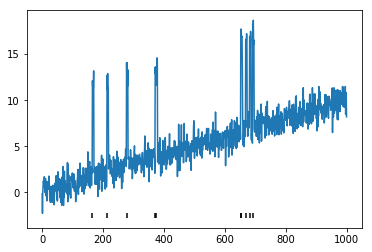

In [4]:
# Plot noisy signal
plt.plot(y)
plt.vlines(t_signal[::dt_signal], ymin=np.min(y)-0.5, ymax=np.min(y))

### Apply real-time filter
Since we are mimicking real-time, we will feed values one at a time. We will also keep in mind that we need to adapt this code to `C`, so we can't get too fancy with indexing or higher-level structures, nor do we want to store any data beyond the buffer size (in the actual implementation). 

Credit: https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data

In [97]:
# Filter settings
n_filt = 50 # length of filter
thresh = 4.0 # number of stds from mean
alpha = 0.0 # influence of datapoint containing signal on buffer

# Initialize buffers
buffer = np.zeros(n_filt)
buffer[:] = y[:n_filt]
buffer_mean = np.mean(buffer)
buffer_std = np.std(buffer)
p = 0 # buffer pointer

# Placeholder (for dev purposes)
y_filt_mean = np.zeros(T) # moving average
y_filt_mean[:n_filt] = buffer_mean
y_filt_std = np.zeros(T)
y_filt_std[:n_filt] = buffer_std
x = np.zeros(T) # signal

# Feed data stream
for t in range(n_filt, T):
    # Get buffer pointer
    p = t % n_filt
    
    # Check if signal threshold passed
    if abs(y[t] - buffer_mean) > thresh*buffer_std:
        # Update signal array
        if (y[t] - buffer_mean) > 0: # positive signal
            x[t] = 1.0
        else: # negative signal
            x[t] = -1.0
            
        # Update buffer
        buffer[p] = alpha*y[t] + (1.0 - alpha)*buffer[p-1]
    else:
        # Update signal and buffer
        x[t] = 0.0
        buffer[p] = y[t]
    
    # Update buffer stats
    buffer_mean = np.mean(buffer)
    buffer_std = np.std(buffer)
    
    # Update filtered data stream (dev)
    y_filt_mean[t] = buffer_mean
    y_filt_std[t] = buffer_std

true positive rate:  0.88 (44 of 50)
false positive rate: 0.00 (0 of 950)
false negative rate: 0.00 (0 of 50)


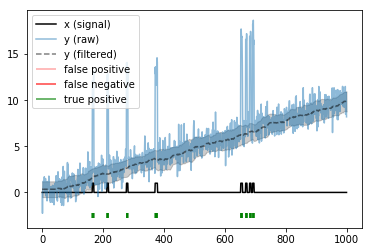

In [98]:
# Plot results
plt.plot(x, color='black', alpha=1.0, linestyle='-', label='x (signal)')
plt.plot(y, color='C0', alpha=0.5, linestyle='-', label='y (raw)')
plt.plot(y_filt_mean, color='black', alpha=0.50, linestyle='--', label='y (filtered)')
plt.fill_between(np.arange(T), y1=y_filt_mean-y_filt_std, y2=y_filt_mean+y_filt_std,
                 color='black', alpha=0.2)

# Plot ground truth
idx_gt = np.zeros(T, dtype=np.bool)
idx_gt[t_signal] = True
idx_tp = np.logical_and(x == 1.0, idx_gt)
idx_fp = np.logical_and(np.abs(x) == 1.0, ~idx_gt)
idx_fn = np.logical_and(x == 0.0, idx_gt)
plt.vlines(np.argwhere(idx_fp).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), 
           alpha=0.35, color='red', label='false positive')
plt.vlines(np.argwhere(idx_fn).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), 
           alpha=0.75, color='red', label='false negative')
plt.vlines(np.argwhere(idx_tp).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), 
           alpha=0.75, color='green', label='true positive')

# Show legend
plt.legend()

# Print results
print('true positive rate:  %.2f (%d of %d)' % (np.sum(idx_tp)/(n_signal*dt_signal), np.sum(idx_tp), n_signal*dt_signal))
print('false positive rate: %.2f (%d of %d)' % (np.sum(idx_fp)/(T - n_signal*dt_signal), np.sum(idx_fp), T - n_signal*dt_signal))
print('false negative rate: %.2f (%d of %d)' % (np.sum(idx_fn)/(n_signal*dt_signal), np.sum(idx_fn), n_signal*dt_signal))

### Save filter

In [8]:
np.savetxt('testFilterData.txt', y)

### Check update functions
Rather than recalculating the new mean and standard deviation of the buffer every iteration, let's try updating the statistics based on the previous values.

In [90]:
# Filter settings
n_filt = 50 # length of filter
thresh = 3.0 # number of stds from mean
alpha = 0.0 # influence of datapoint containing signal on buffer

# Initialize buffers
buffer = np.zeros(n_filt)
buffer[:] = y[:n_filt]
buffer_mean = np.mean(buffer)
buffer_std = np.std(buffer)
p = 0 # buffer pointer

# Placeholder (for dev purposes)
y_filt_mean = np.zeros(T) # moving average
y_filt_mean[:n_filt] = buffer_mean
y_filt_std = np.zeros(T)
y_filt_std[:n_filt] = buffer_std
x = np.zeros(T) # signal

# New method placeholders
y_filt_mean_ = np.zeros(T) # moving average
y_filt_mean_[:n_filt] = buffer_mean
y_filt_std_ = np.zeros(T)
y_filt_std_[:n_filt] = buffer_std
N = n_filt

# Feed data stream
for t in range(n_filt, T):
    # Get buffer pointer
    p = t % n_filt
    
    # Cache
    buffer_old = buffer[p]
    
    # Check if signal threshold passed
    if abs(y[t] - buffer_mean) > thresh*buffer_std:
        # Update signal array
        if (y[t] - buffer_mean) > 0: # positive signal
            x[t] = 1.0
        else: # negative signal
            x[t] = -1.0
            
        # Update buffer
        buffer[p] = alpha*y[t] + (1.0 - alpha)*buffer[p-1]
    else:
        # Update signal and buffer
        x[t] = 0.0
        buffer[p] = y[t]
    
    # Update buffer stats (old method)
    buffer_mean = np.mean(buffer)
    buffer_std = np.std(buffer)
    
    # Update buffers stats (new method)
    y_filt_mean_[t] = y_filt_mean_[t-1] + (1/N)*(buffer[p] - buffer_old)
    dmean = (1/N)*(buffer[p] - buffer_old)
    y_filt_std_[t] = (y_filt_std_[t-1]**2 - (1/N)*(buffer_old - y_filt_mean_[t-1])**2 + (1/N)*(buffer[p] - y_filt_mean_[t])**2
                      + (2*dmean/N)*(buffer_old - y_filt_mean_[t-1]) + ((N-1)/N)*(dmean**2))**0.5
    
    # Update filtered data stream (dev)
    y_filt_mean[t] = buffer_mean
    y_filt_std[t] = buffer_std

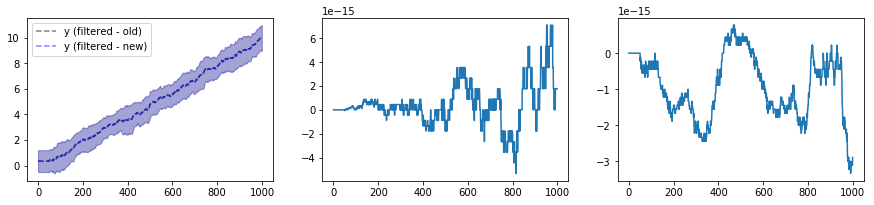

In [95]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

# Plot results
ax[0].plot(y_filt_mean, color='black', alpha=0.50, linestyle='--', label='y (filtered) (old)')
ax[0].fill_between(np.arange(T), y1=y_filt_mean-y_filt_std, y2=y_filt_mean+y_filt_std,
                 color='black', alpha=0.2)
ax[0].plot(y_filt_mean_, color='blue', alpha=0.50, linestyle='--', label='y (filtered) (new)')
ax[0].fill_between(np.arange(T), y1=y_filt_mean_-y_filt_std_, y2=y_filt_mean_+y_filt_std_,
                 color='blue', alpha=0.2)
ax[0].legend()

# Plot differences
ax[1].plot(y_filt_mean - y_filt_mean_)
ax[2].plot(y_filt_std - y_filt_std_)

Pretty accurate with some drifting over time. It looks like a nice compromise would be to recalculate the ground truth mean and standard deviation every so many iterations to zero out the drift occasionally.

### c++ implementation

In [2]:
y_cpp = np.loadtxt('../data/testFilterData.txt')
x_cpp = np.loadtxt('../data/signal.txt')

true positive rate:  0.00 (0 of 50)
false positive rate: 0.05 (44 of 950)
false negative rate: 0.94 (47 of 50)


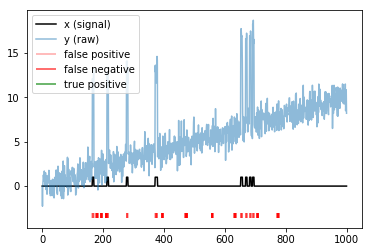

In [5]:
# Plot results
plt.plot(x_cpp, color='black', alpha=1.0, linestyle='-', label='x (signal)')
plt.plot(y_cpp, color='C0', alpha=0.5, linestyle='-', label='y (raw)')

# Plot ground truth
idx_gt = np.zeros(T, dtype=np.bool)
idx_gt[t_signal] = True
idx_tp = np.logical_and(x_cpp == 1.0, idx_gt)
idx_fp = np.logical_and(np.abs(x_cpp) == 1.0, ~idx_gt)
idx_fn = np.logical_and(x_cpp == 0.0, idx_gt)
plt.vlines(np.argwhere(idx_fp).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), 
           alpha=0.35, color='red', label='false positive')
plt.vlines(np.argwhere(idx_fn).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), 
           alpha=0.75, color='red', label='false negative')
plt.vlines(np.argwhere(idx_tp).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), 
           alpha=0.75, color='green', label='true positive')

# Show legend
plt.legend()

# Print results
print('true positive rate:  %.2f (%d of %d)' % (np.sum(idx_tp)/(n_signal*dt_signal), np.sum(idx_tp), n_signal*dt_signal))
print('false positive rate: %.2f (%d of %d)' % (np.sum(idx_fp)/(T - n_signal*dt_signal), np.sum(idx_fp), T - n_signal*dt_signal))
print('false negative rate: %.2f (%d of %d)' % (np.sum(idx_fn)/(n_signal*dt_signal), np.sum(idx_fn), n_signal*dt_signal))

### Arduino implementation
The limited Arduino processor imposes a trade-off between buffer size (which increases time to update the filter) and sampling rate (which sets the minimum sampling period and thus filter update frequency). That is, the longer the buffer, the slower the sampling rate must be; otherwise, the time to update the buffer will exceed the sampling rate, leading to unintended slow buffers that lag in real-time (e.g. fill every 5 seconds instead of every second). 

NOTE: The following data was acquired using an Arduino MEGA 2560.

EDIT: This only applies to naive buffer statistics calculations. If one-sample updates are used instead, then filter calculations take roughly constant time (see below):

| buffer size<sup>a</sup> (n) | sensitivity (a.u.) | time per iteration, one sensor (us) | time per iteration, two sensors (us) |
| --------------- | --------------- | ----------------------- | ----------------------- |
| 0<sup>b</sup> | - | 500 | 500 |
| 0<sup>c</sup>  | 30 | 1500 | 3300 | 
| <i></i> | 60 | 3900 | 8800 |
| <i></i> |120 | 7500 | 17300 |
|  1-1500<sup>d</sup>  | 30 | 2000 | 4300 |
|  <i></i>  | 60 | 4400 | 9700 |
|  <i></i>  | 120 | 8000 | 18200 |
|  2000+ | 30 | memory overflow | memory overflow |
|  <i></i> | 60 | memory overflow | memory overflow |
|  <i></i> | 120 | memory overflow | memory overflow |

a. The *total* number of elements across all filters (e.g. one filter with a buffer size of 1000, or two buffers with a size of 500 each)

b. only `time` and `Serial.print()` functions

c. above plus `CapacitiveSensor(sensitivity)`

d. above plus `MovingFilter` of type `long`

Although not perfect, we will roughly assume a linear relationship of the above constraints, leading to the following guidelines:

$
\quad sampleRate \leq \dfrac{500}{(nSensors)(\frac{sensitivity}{30})} \\
\quad tFilter \leq \dfrac{1500}{(nSensors)(sampleRate)}
$

### Parameter settings
Finding the right parameter space for the filter can be tricky. Let's take a look at some different considerations.

#### On-off time
A nice feature of this filter is that it will automatically turn the signal off if a new baseline is reached (e.g. a wire touches something nearby, or a drop of water stays on the spout). What is the time to setting the new baseline and thereby turning off the signal?

Let's say the original baseline is drawn from $y_t \sim \mathcal{N}(y, \sigma)$ and that new baseline suddenly becomes $y'_t \sim \mathcal{N}(y', \sigma')$, where $y' = y + k$, and $k > \gamma \sigma$. Therefore, the filter recognizes the incoming data stream as a signal, and applies the filter accordingly to update the buffer $\mathbf{x}$:

$
\quad x_t = \alpha y'_t + (1 - \alpha) x_{t-1}
$

In order to ensure detection of the shift in baseline, the set of parameters $\beta = 1 - \alpha$, $\gamma$, and buffer size $n$ must satisfy the following inequality:

$
\gamma^2 - \dfrac{\left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{n \left ( \beta - 1 \right ) \left (1 - \beta^{-2n} \right ) - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right )} \geq 0
$

Derivation of this inequality is shown in the Appendix below.

Let's plot some examples:

In [3]:
def sum_x_exp(alpha, t, n, exp=1):
    base = (1.0-alpha)*np.ones(n)
    exp = exp*np.arange(t-n+1, t+1)
    exp[exp < 0] = 0
    return np.sum(np.power(base, exp))

def get_off_time(alpha=None, n=None, gamma=None):
    def _make_array(a):
        if not isinstance(a, np.ndarray):
            return np.array([a])
        else:
            return a

    # Check parameters
    if sum([p is None for p in [alpha, n, gamma]]) > 1:
        raise ValueError('Too many unknowns.')
    elif sum([p is None for p in [alpha, n, gamma]]) == 0:
        raise ValueError('No unknowns to solve.')
        
    # Solve for gamma
    elif gamma is None:
        # Make array form
        n = _make_array(n)
        alpha = _make_array(alpha)
        if (alpha >= 1.0).any() or (alpha <= 0.0).any():
            raise ValueError('alpha must be between 0.0 and 1.0')
        
        # Summation form
        #sum_x_1 = sum_x_exp(alpha, t, n, exp=1)
        #sum_x_2 = sum_x_exp(alpha, t, n, exp=2)
        #return (n*sum_x_2/sum_x_1**2 - 1.0)**-0.5
        
        # No summation form
        beta = 1.0 - alpha
        num = (1.0 - beta**(-n))**2 * (beta + 1)
        den = n*(1.0- beta**(-2*n))*(beta - 1) - num
        return (num / den)**0.5
        
    # Solve for n
    elif n is None:
        # Make array form
        gamma = _make_array(gamma)
        alpha = _make_array(alpha)
        if (alpha >= 1.0).any() or (alpha <= 0.0).any():
            raise ValueError('alpha must be between 0.0 and 1.0')
        
        # Define zero equation
        beta = 1.0 - alpha
        def F(n):
            num = (1.0 - beta**(-n))**2 * (beta + 1)
            den = n*(1.0 - beta**(-2*n))*(beta - 1) - num
            return gamma**2 - (num/den) 
        
        # Initial value is important since curvature is very flat
        # far from solution, leading to NoConvergence unless initial guess
        # is reasonable. Try over range of initial values.
        x_inits = [1.0001, 1.1, 5, 25, 125]
        for x_init in x_inits:
            try:
                # Attempt to solve with x_init. 
                # Because equation is even (f(x) = f(-x); see Appendix),
                # we can return absolute value of either solution
                x_init = x_init*np.ones(gamma.shape)
                return np.abs(broyden1(F, x_init))
            
            except (NoConvergence, FloatingPointError):
                continue
        
        return np.full(gamma.shape, np.nan)
    
    elif alpha is None:
        # Make array form
        n = _make_array(n)
        gamma = _make_array(gamma)
        
        # Define zero equation
        def F(beta):
            num = (1.0 - beta**(-n))**2 * (beta + 1)
            den = n*(1.0 - beta**(-2*n))*(beta - 1) - num
            return gamma**2 - (num/den) 
        
        # Initial value is important since curvature is very flat
        # far from solution, leading to NoConvergence unless initial guess
        # is reasonable. Try over range of initial values.
        odd_failure = False
        x_inits = np.logspace(-5, -0.1, 100)
        for x_init in x_inits:
            try:
                # Attempt to solve with x_init. 
                x_init = x_init*np.ones(gamma.shape)
                alpha_soln = np.ones(gamma.shape) - broyden1(F, 1.0 - x_init)
                
                # Even n values create an even equation, so
                # positive or negative solution acceptable
                idx = (n % 2 == 0)
                alpha_soln[idx] = np.abs(alpha_soln[idx])
                
                # Odd values do not create either even or odd equation,
                # so must be thrown out
                if (alpha_soln[~idx] < 0.0).any():
                    odd_failure = True
                    continue
                
                return alpha_soln
            
            except (NoConvergence, FloatingPointError):
                continue
        
        if odd_failure:
            print('Failed to find solution due to odd n values. Try entering '
                  'only even values instead.')
        return np.full(gamma.shape, np.nan)
        
def buffer_mean(alpha, t, n, k):
    return k - (k/n)*sum_x_exp(alpha, t, n, exp=1)

def buffer_std(alpha, t, n, k):
    return (k/n)*(n*sum_x_exp(alpha, t, n, exp=2) - (sum_x_exp(alpha, t, n, exp=1))**2)**0.5

k: 100.00
n: 10
alpha: 0.10
gamma: 3.34


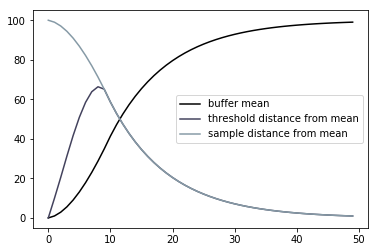

In [4]:
alpha = 0.1
n = 10
k = 100
t = np.arange(0, 5*n)
gamma = get_off_time(alpha=alpha, n=n)
mean = np.zeros(t.size)
std = np.zeros(t.size)
for i, t_i in enumerate(t):
    mean[i] = buffer_mean(alpha, t_i, n, k)
    std[i] = buffer_std(alpha, t_i, n, k)
    
fig, ax = plt.subplots()
plt.plot(t, mean, 
         label='buffer mean',
         color=cmap(0.0))
plt.plot(t, std*gamma, 
         label='threshold distance from mean', 
         color=cmap(0.3))
plt.plot(t, k - mean, 
         label='sample distance from mean',
         color=cmap(0.6))
plt.legend()

print('k: %.2f' % k)
print('n: %d' % n)
print('alpha: %.2f' % alpha)
print('gamma: %.2f' % gamma)

From the plot above, we can see why we lose $t$ dependence in the inequality that governs parameter relationships. Once the buffer has been completely filled with samples from the signal, both the sample distance from the mean, $y'_t - \mu_t$, and the threshold distance from the mean, $\gamma \sigma_t$, decay exponentially. Thus they will either overlap exactly, or never at all, though their difference will approach zero over time. Of course, in reality $\sigma' \neq 0$, so any one sample could trigger the off-time. A more realistic constraint would be to specify that the mean sample distance from mean is within some distance $\epsilon$ from the threshold:

$
\quad y'_t  - \mu_t \leq \gamma \sigma_t \\
\quad \Rightarrow (y' - \epsilon) - \mu_t \leq \gamma \sigma_t \\
\quad \Rightarrow y + k - \mu_t \leq \gamma \sigma_t + \epsilon
$

so that a sample drawn from $\mathcal{N}(y', \sigma')$ within $\epsilon$ of the buffer threshold will trigger the signal to off.

This would lead to an additional term in the inequality that is dependent on $t$:

$
\gamma^2 - \left ( \sqrt{\dfrac{\left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{n \left ( \beta - 1 \right ) \left (1 - \beta^{-2n} \right ) - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right )}} - \dfrac{\epsilon}{\dfrac{k}{n}\sqrt{n \sum_{i=t-n+1}^{t} \beta^{2i} - \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2}} \right )^2 \geq 0
$

since the denominator of the expression with $\epsilon$ no longer has a $\beta^{2t}$ term to cancel out in the numerator. To solve for $t$, we would first need to convert the summation to the exponential form (containing the $\beta^{2t}$ term) before passing the ever more complicated expression to a non-linear solver. For now, a story for another day :-)

Instead, we will focus on a solution that, on average, will trigger the signal off after one full run-through of the buffer. Let's look at a range of solutions in this constrained parameter space to get a sense of what we could potentially use for our implementation:

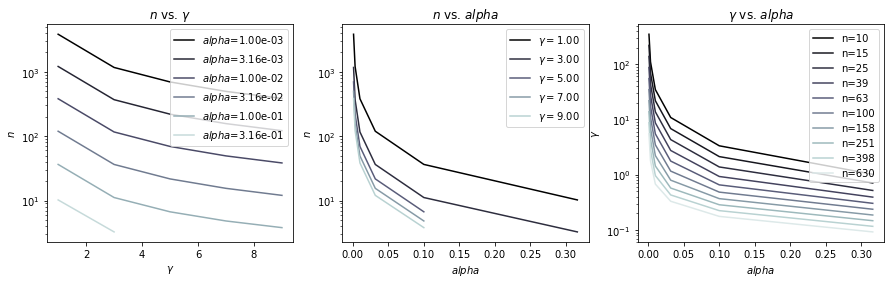

In [458]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# Range to plot
alpha_range = [10**x for x in np.linspace(-3, 0, 7)[:-1]]
gamma_range = np.arange(1, 10, 2)
n_range = np.logspace(1, 2.8, 10)

# Find parameters solutions given constraints
n_soln = np.zeros([len(alpha_range), len(gamma_range)])
gamma_soln = np.zeros([len(alpha_range), len(n_range)])
for i, alpha in enumerate(alpha_range):
    for j, gamma in enumerate(gamma_range):
        n_soln[i, j] = get_off_time(alpha, gamma=gamma)
    for k, n in enumerate(n_range):
        gamma_soln[i, k] = get_off_time(alpha, n=n)
            
# Plot n vs. gamma for fixed alpha
for i, alpha in enumerate(alpha_range):
    ax[0].plot(gamma_range, n_soln[i, :], 
               label='$alpha$=%.2e' % alpha,
               color=cmap(i/len(alpha_range)))
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xlabel('$\gamma$')
ax[0].set_ylabel('$n$')
ax[0].set_title('$n$ vs. $\gamma$')

# Plot n vs. alpha for fixed gamma
for j, gamma in enumerate(gamma_range):
    ax[1].plot(alpha_range, n_soln[:, j], 
               label='$\gamma=%.2f$' % gamma,
               color=cmap(j/len(gamma_range)))
ax[1].legend()
#ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('$alpha$')
ax[1].set_ylabel('$n$')
ax[1].set_title('$n$ vs. $alpha$')

# Plot alpha vs. gamma for fixed n
for k, n in enumerate(n_range):
    ax[2].plot(alpha_range, gamma_soln[:, k], 
               label='n=%d' % n,
               color=cmap(k/len(n_range)))
ax[2].legend()
#ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel('$alpha$')
ax[2].set_ylabel('$\gamma$')
ax[2].set_title('$\gamma$ vs. $alpha$');

Now that we have an idea of the range we're working with, let's find an exact solution given some constraints. We know that:

1. $n \geq 100$ to buffer noise appropriately
2. $n \leq 1500$ due to Arduino memory constraints
3. $\gamma \geq 3.0$ to limit false positives
4. $\gamma \leq 5.0$ to limit false negatives

Looking at the above graphs, it's clear that $\alpha$ needs to be small from the $\gamma$ vs. $\alpha$ plot given that we want a decent buffer size $n$. I will choose $n = 100$ and $\gamma = 5.0$.

In [9]:
# Find specific solution
n = 100
gamma = 5.0
alpha = get_off_time(n=n, gamma=gamma)

print('Parameters: n=%d, gamma=%.2f, alpha=%.5f' % (n, gamma, alpha))

Parameters: n=100, gamma=5.00, alpha=0.00693


## Appendix

### One-sample update

While the mean and standard deviation of the buffer can be trivially calculated from their definitions:

$
\quad \mu = \frac{1}{N} \sum_n y_n \\
\quad \sigma^2 = \frac{1}{N} \sum_n \left ( y_n - \mu \right )^2
$

this can become expensive with larger buffers (growing $\sim O(N)$). Since the time to update the buffer statistics limits the rate at which the signal can be detected, minimizing calculation time is important. This can be done by updating the current statistics based only on the new sample. Let's say the new sample $x'_j$ replaces the old sample $x_j$ at the $j^{th}$ position in the buffer. The new mean $\mu'$ becomes:

$
\quad \mu  = \frac{1}{N} \left ( \sum_{i \neq j} x_i + x_j  \right ) \\
\quad \mu' = \frac{1}{N} \left ( \sum_{i \neq j} x_i + x'_j \right ) \\
\quad \mu' - \mu = \Delta\mu = \frac{1}{N} \left ( x'_j - x_j \right ) \\
\quad \Rightarrow \mu' = \mu + \frac{1}{N} \left ( x'_j - x_j \right )
$

and the new standard deviation $\sigma'$ becomes:

$
\begin{align}
\quad \sigma^2 = \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i - \mu \right )^2 + \left ( x_j - \mu \right )^2 \right ]
\end{align}
$

$
\begin{align}
\quad \sigma'^2 
&= \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i - \mu' \right )^2 + \left ( x'_j - \mu' \right )^2 \right ] \\
&= \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i - (\mu + \Delta\mu) \right )^2 + \left ( x'_j - \mu' \right )^2 \right ] \\
&= \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i - \mu - \Delta\mu \right )^2 + \left ( x'_j - \mu' \right )^2 \right ] \\
&= \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i^2 - 2x_i\mu + \mu^2 \right ) - \sum_{i \neq j} \left ( 2x_i\Delta\mu \right ) + \sum_{i \neq j} \left ( 2\mu\Delta\mu + \Delta\mu^2 \right ) + \left ( x'_j - \mu' \right )^2 \right ] \\
&= \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i - \mu \right )^2 - 2\Delta\mu \sum_{i \neq j} x_i + \left ( N - 1 \right ) \left ( 2\mu\Delta\mu + \Delta\mu^2 \right ) + \left ( x'_j - \mu' \right )^2 \right ] \\
&= \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i - \mu \right )^2 + \left (x_j - \mu \right )^2 - \left (x_j - \mu \right )^2 \right ] + \frac{1}{N} \left [ - 2\Delta\mu \left ( N\mu - x_j \right ) + \left ( N - 1 \right ) \left ( 2\mu\Delta\mu + \Delta\mu^2 \right ) + \left ( x'_j - \mu' \right )^2 \right ] \\
&= \sigma^2 - \frac{1}{N} \left ( x_j - \mu \right )^2 + \frac{1}{N} \left ( x'_j - \mu' \right )^2 + \frac{1}{N} \left [ - 2N\mu\Delta\mu + 2\Delta\mu x_j + 2N\mu\Delta\mu + N\Delta\mu^2 - 2\mu\Delta\mu - \Delta\mu^2 \right ] \\
&= \sigma^2 - \frac{1}{N} \left ( x_j - \mu \right )^2 + \frac{1}{N} \left ( x'_j - \mu' \right )^2 + \frac{1}{N} \left [ 2\Delta\mu \left ( x_j - \mu \right ) + \left ( N - 1 \right ) \Delta\mu^2 \right ] \\
&= \sigma^2 - \frac{1}{N} \left ( x_j - \mu \right )^2 + \frac{1}{N} \left ( x'_j - \mu' \right )^2 + \frac{2\Delta\mu}{N} \left ( x_j - \mu \right ) + \frac{N - 1}{N} \Delta\mu^2
\end{align}
$

which grows with constant time. Note that some drift may occur due to rounding errors over time, which can be corrected by occassionally calculating the mean and standard deviation over the entire buffer.

### Off-time responsiveness

#### Off-time parameter relationship
Here, we will assume that $\sigma' = 0$ for simplicity. Let's work backwards from time $t$ (we will write $(1 - \alpha) = \beta$ for readability):

$
\begin{align}
\quad x_t 
&= \alpha y' + \beta x_{t-1} \\
&= \alpha y' + \beta (\alpha y' + \beta x_{t-2}) \\
&= \alpha y' + \alpha \beta y' + \beta^2 x_{t-2} \\
&= \alpha y' + \alpha \beta y' + \beta^2 (\alpha y' + \beta x_{t-3}) \\
&= \alpha y' + \alpha \beta y' + \alpha \beta^2 y' + \beta^3 x_{t-3} \\
& \vdots \\
&= \sum_{i = 0}^{t-1} \alpha \beta^i y' + \beta^t y_0 \\
&= \alpha y' \sum_{i = 0}^{t-1} \beta^i + \beta^t y \quad (\text{since } y_0 = y) \\
&= \alpha \left ( y + k \right ) \sum_{i = 0}^{t-1} \beta^i + \beta^t y \\
&= \alpha y \sum_{i = 0}^{t-1} \beta^i + \beta^t y + \alpha k \sum_{i = 0}^{t-1} \beta^i \\
&= y \left ( \alpha \sum_{i = 0}^{t-1} \beta^i + \beta^t \right ) + \alpha k \sum_{i = 0}^{t-1} \beta^i \\
&= y + \alpha k \sum_{i = 0}^{t-1} \beta^i \quad (\text{since } \alpha \sum_{i = 0}^{t-1} \beta^i + \beta^t = 1) \\
&= y + k \left ( 1 - \beta^t \right ) \quad (\text{for same reason as above})
\end{align}
$

With a buffer of size $n$, the mean and standard deviation at time $t$ is:

$
\begin{align}
\quad \mu_t
&= \frac{1}{n} \sum_{i=t-n+1}^{t} x_i \\
&= \frac{1}{n} \sum_{i=t-n+1}^{t} \left [ y + k \left ( 1 - \beta^i \right ) \right ] \\
&= \frac{1}{n} \sum_{i=t-n+1}^{t} y + \frac{k}{n} \sum_{i=t-n+1}^{t} \left ( 1 - \beta^i \right ) \\
&= y + \frac{k}{n} \left ( n - \sum_{i=t-n+1}^{t} \beta^i \right ) \\
&= y + k - \frac{k}{n} \sum_{i=t-n+1}^{t} \beta^i
\end{align}
$

$
\begin{align}
\quad \sigma^2_t
&= \mathbb{E}_t[X^2] - \mathbb{E}_t[X]^2 \\
&= \frac{1}{n} \sum_{i=t-n+1}^{t} \left ( x_i^2 \right ) - \mu_t^2 \\
&= \frac{1}{n} \sum_{i=t-n+1}^{t} \left ( y + k \left ( 1 - \beta^i \right ) \right )^2 - \left ( y + \frac{k}{n} \sum_{i=t-n+1}^{t} \left ( 1 - \beta^i \right ) \right )^2 \\
&= \frac{1}{n} \sum_{i=t-n+1}^{t} \left ( y^2 + 2 y k \left ( 1 - \beta^i \right ) + k^2 \left  (1 - \beta^i \right )^2 \right ) - \left ( y^2 + + \dfrac{2 y k}{n} \sum_{i=t-n+1}^{t} \left ( 1 - \beta^i \right ) + \left ( \frac{k}{n} \sum_{i=t-n+1}^{t} \left ( 1 - \beta^i \right ) \right )^2 \right ) \\
&= \dfrac{1}{n} \sum_{i=t-n+1}^{t} y^2 + \dfrac{2 y k}{n} \sum_{i=t-n+1}^{t} \left ( 1 - \beta^i \right ) + \dfrac{k^2}{n} \left ( \sum_{i=t-n+1}^{t} \left ( 1 - \beta^i \right )^2 \right ) \\ &\quad - y^2 - \dfrac{2 y k}{n} \sum_{i=t-n+1}^{t} \left ( 1 - \beta^i \right ) - \frac{k^2}{n^2} \left ( n - \sum_{i=t-n+1}^{t} \beta^i \right )^2 \\
&= y^2 - y^2 + \dfrac{2 y k}{n} \sum_{i=t-n+1}^{t} \left ( 1 - \beta^i \right ) - \dfrac{2 y k}{n} \sum_{i=t-n+1}^{t} \left ( 1 - \beta^i \right ) \\ &\quad + \dfrac{k^2}{n} \left ( \sum_{i=t-n+1}^{t} \left ( 1 - 2 \beta^i + \beta^{2i} \right ) \right ) - \dfrac{k^2}{n^2} \left ( n^2 - 2 n \sum_{i=t-n+1}^{t} \beta^i + \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2  \right ) \\
&= \dfrac{k^2}{n} \left (  n - 2 \sum_{i=t-n+1}^{t} \beta^i + \sum_{i=t-n+1}^{t} \beta^{2i} \right ) - \dfrac{k^2}{n^2} \left ( n^2 - 2 n \sum_{i=t-n+1}^{t} \beta^i + \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2  \right ) \\
&= k^2 - \dfrac{2 k^2}{n} \sum_{i=t-n+1}^{t} \beta^i + \dfrac{k^2}{n} \sum_{i=t-n+1}^{t} \beta^{2i} - k^2 + \dfrac{2 k^2}{n} \sum_{i=t-n+1}^{t} \beta^i - \dfrac{k^2}{n^2} \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2 \\
&= \dfrac{k^2}{n} \left ( \sum_{i=t-n+1}^{t} \beta^{2i} - \dfrac{1}{n} \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2 \right )
\end{align}
$

The time $t^*$ at which the new baseline is set occurs when the condition $y'_t - \mu_t \leq \gamma \sigma_t$ is met:

$
\begin{align}
\quad y' 
&\leq \mu_t + \gamma \sigma_t \\
\Rightarrow y + k 
&\leq y + k - \frac{k}{n} \sum_{i=t-n+1}^{t} \beta^i + \gamma \sqrt{\dfrac{k^2}{n} \left ( \sum_{i=t-n+1}^{t} \beta^{2i} - \dfrac{1}{n} \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2 \right )} \\
\Rightarrow 0 
&\leq - \frac{k}{n} \sum_{i=t-n+1}^{t} \beta^i + \gamma \sqrt{\dfrac{k^2}{n} \left ( \sum_{i=t-n+1}^{t} \beta^{2i} - \dfrac{1}{n} \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2 \right )}
\end{align}
$

For a given datastream $y$, $k$ and buffer parameter $\alpha$, we have three variables–$n$, $t$, and $\gamma$–whose relationship is defined by the equation above. Let's examine each of the three variables:

$
\begin{align}
\quad \gamma 
&\geq \dfrac{\dfrac{k}{n} \sum_{i=t-n+1}^{t} \beta^i}{ \sqrt{\dfrac{k^2}{n} \left ( \sum_{i=t-n+1}^{t} \beta^{2i} - \dfrac{1}{n} \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2 \right )}} \\
&\geq \dfrac{\dfrac{k}{n} \sum_{i=t-n+1}^{t} \beta^i}{ \dfrac{k}{n}\sqrt{n \sum_{i=t-n+1}^{t} \beta^{2i} - \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2}} \\
&\geq \dfrac{\sum_{i=t-n+1}^{t} \beta^i}{\sqrt{n \sum_{i=t-n+1}^{t} \beta^{2i} - \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2}} \\
&\geq \sqrt{ \dfrac{\left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2}{n \sum_{i=t-n+1}^{t} \beta^{2i} - \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2}}
\end{align}
$

If we rewrite the summations using the identity $\sum_{i=j}^{k} \beta^{mi} = \frac{\beta^{k+1} - \beta^j}{\beta^m - 1}$:

$
\begin{align}
\quad \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2
&= \left ( \dfrac{\beta^{t+1} - \beta^{t-n+1}}{\beta - 1} \right )^2 \\
&= \dfrac{\beta^{2t} \left ( \beta - \beta^{1-n} \right )^2}{\left ( \beta - 1 \right )^2}
\end{align}
$

$
\begin{align}
\quad \sum_{i=t-n+1}^{t} \beta^{2i}
&= \dfrac{\beta^{2(t+1)} - \beta^{2(t-n+1)}}{\beta^2 - 1} \\
&= \dfrac{\beta^{2t} \left ( \beta^2 - \beta^{2n - 2} \right )}{\left ( \beta + 1 \right ) \left ( \beta - 1 \right )}
\end{align}
$

We arrive at the following equivalent expression for $\gamma$:

$
\begin{align}
\quad \gamma
&\geq \sqrt{ \dfrac{\left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2}{n \sum_{i=t-n+1}^{t} \beta^{2i} - \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2}} \\
&\geq \sqrt{\dfrac{\dfrac{\beta^{2t} \left ( \beta - \beta^{1-n} \right )^2}{\left ( \beta - 1 \right )^2}}{n \dfrac{\beta^{2t} \left ( \beta^2 - \beta^{2n - 2} \right )}{\left ( \beta + 1 \right ) \left ( \beta - 1 \right )} - \dfrac{\beta^{2t} \left ( \beta - \beta^{1-n} \right )^2}{\left ( \beta - 1 \right )^2}} \cdot \dfrac{\left ( \beta - 1 \right )^2 \left ( \beta + 1 \right )}{\left ( \beta - 1 \right )^2 \left ( \beta + 1 \right )}} \\
&\geq \sqrt{\dfrac{\beta^2 \left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{\beta^2 \left ( n \left ( \beta - 1 \right ) \left (1 - \beta^{-2n} \right ) - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right ) \right )}} \\
&\geq \sqrt{\dfrac{\left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{n \left ( \beta - 1 \right ) \left (1 - \beta^{-2n} \right ) - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right )}}
\end{align}
$

Interestingly, the equation is entirely defined by $\alpha$, $n$, and $\gamma$; in other words, the off-time is independent of the data stream ($y$ or $k$) and the actual time after the baseline shift ($t$). The independence from data is 1) convenient because we don't have to tailor our parameters to particular baselines or baseline shifts, and 2) intuitive because as $k$ grows, so do both $y'_t - \mu_t$ and $\gamma \sigma_t$. The independence from time is puzzling at first, since we can no longer solve for the time at which the baseline shift will be detected. However, as is clear from the plots below, this is because the solution for $t$ is all or nothing: either the condition $y'_t - \mu_t \leq \gamma \sigma_t$ is satisfied for all $t$ (after one buffer run-through) or never. Lastly, we can rearrange the above equation to more conveniently solve for $n$:

$
\begin{align}
\quad &\gamma
\geq \sqrt{\dfrac{\left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{n \left ( \beta - 1 \right ) \left (1 - \beta^{-2n} \right ) - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right )}} \\
\quad &\Rightarrow \gamma^2
\geq \dfrac{\left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{n \left ( \beta - 1 \right ) \left (1 - \beta^{-2n} \right ) - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right )} \\
\quad &\Rightarrow \gamma^2 - \dfrac{\left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{n \left ( \beta - 1 \right ) \left (1 - \beta^{-2n} \right ) - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right )} \geq 0
\end{align}
$

Thus to find the bounds of parameter space that ensures detection, we must find the zeros of the equation:

$
f(\beta, \gamma, n) = \gamma^2 - \dfrac{\left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{n \left ( \beta - 1 \right ) \left (1 - \beta^{-2n} \right ) - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right )}
$

#### Proof that summation is equal to one

Here's a funny aside. I initially had forgotten the old value in the summation term, leading to the equation:

$
\quad x_t = y' \left ( \alpha \sum_{j = 0}^{i-1} \beta^j + \beta^i \right ) \\
\quad \sigma_t^2 = \frac{y'^2}{n^2} \left [ \sum_{i=t-n+1}^{t} \left ( \alpha \sum_{j = 0}^{i-1} \beta^j + \beta^i \right )^2 - \left ( \sum_{i=t-n+1}^{t} \left ( \alpha \sum_{j = 0}^{i-1} \beta^j + \beta^i \right ) \right )^2 \right ]
$

But, of course, if all terms in the buffer were $y'$ to begin, then the buffer should never change: $x_t = y', \sigma_t^2 = 0 \quad \forall t$. And this is what happens! As it turns out, $\alpha \sum_{j = 0}^{i-1} \beta^j + \beta^i = 1$, where $\beta = (1 - \alpha)$. Let's prove this:

$
\begin{align}
\quad S(i-1) 
&= \alpha \sum_{j = 0}^{i-2} (1 - \alpha)^j + (1 - \alpha)^{i-1} \\
&= \alpha \sum_{j = 0}^{i-1} (1 - \alpha)^j - \alpha (1 - \alpha)^{i-1} + (1 - \alpha)^{i-1} \\
&= \alpha \sum_{j = 0}^{i-1} (1 - \alpha)^j + (1 - \alpha) (1 - \alpha)^{i-1} \\
&= \alpha \sum_{j = 0}^{i-1} (1 - \alpha)^j + (1 - \alpha)^{i} \\
&= S(i)
\end{align}
$

$
\quad \Rightarrow S(i) = S(i-1) = \cdots = S(0) = 1
$

#### Proof that equation is even
The equation for solving for the filter parameters is even, meaning that $f(n) = f(-n)$. Let's make use of the following equations:

$
\left ( 1 - \beta^{n} \right )^2 = \left ( \beta^{-n} - 1 \right )^2 = \left ( 1 - \beta^{-n} \right )^2 \\
\left (1 - \beta^{2n} \right ) = \left (\beta^{-2n} - 1 \right )
$

where we multiplied each term in the initial expressions by $\beta^{-n}$ and $\beta^{-2n}$, respectively. We can then prove that the equation is even by substituting $-n$ for $n$:

$
\begin{align}
f(-n)
&= \gamma^2 - \dfrac{\left ( 1 - \beta^{-(-n)} \right )^2 \left (\beta + 1 \right )}{(-n) \left (1 - \beta^{-2(-n)} \right ) \left ( \beta - 1 \right ) - \left ( 1 - \beta^{-(-n)} \right )^2 \left ( \beta + 1 \right )} \\
&= \gamma^2 - \dfrac{\left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{(-n) \left (\beta^{-2n} - 1 \right ) \left ( \beta - 1 \right )  - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right )} \\
&= \gamma^2 - \dfrac{\left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{n \left (1 - \beta^{-2n} \right ) \left ( \beta - 1 \right )  - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right )} \\
&= f(n)
\end{align}
$

As we can see from the plot below, the equation is even with respect to $n$. Thus non-linear solvers can obtain either the positive or negative solution when attempting to find $n$ given $\alpha$, $\gamma$. Moreover, it is clear that $\lim_{|n| \to 1} f(n) = +\infty$ and $\lim_{|n| \to \infty} f(n) = 0$.

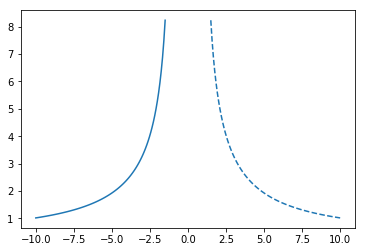

In [402]:
# Plot f(-n) and f(n)
n = np.linspace(1.5, 10, 100)
plt.plot(-n, get_off_time(alpha, n=-n), color='C0')
plt.plot(n, get_off_time(alpha, n=n), color='C0', linestyle='--');

This also holds true for $\beta = 1.0 - \alpha$ if $n = 2m$ is even, since $(-\beta)^{2m} = ((-\beta)^2)^m = (\beta^2)^m = \beta^{2m}$. However, it does not hold for odd (or non-integer) values of $n$.